# Demo how to make predictions with OSnet, using all built-in default variables

|<img src="https://github.com/euroargodev/OSnet-GulfStream/raw/main/docs/_static/osnet_landscape.png" width="300px"/>|
|:---------:|
|``OSnet`` is a python library to make T/S/MLD predictions in the Gulf Stream Extension using Neural Network|

<b>Warning: These predictions are made using climatological input fields for SST and SLA !</b>

This notebook requires cartopy, cmocean and argopy

In [1]:
import os, sys

# Assume OSnet is one parent folder away from this notebook:
sys.path.insert(0, os.path.split(os.path.abspath(os.path.curdir))[0])  
import osnet
from osnet.options import OPTIONS
osnet.disclaimer()

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import argopy

# For plots
xr.set_options(display_style="text", display_expand_attrs=False);
import matplotlib.pyplot as plt
import colorcet as cc
import cmocean
import time
import cartopy.crs as ccrs

# Dictionnary of colormaps for variables
cmapd = {'BATHY': cmocean.cm.topo, 
      'MDT': cmocean.cm.delta, 
      'SST': cmocean.cm.thermal, 
      'SLA': cmocean.cm.balance, 
      'UGOSA': cmocean.cm.balance, 
      'VGOSA': cmocean.cm.balance, 
      'UGOS': cmocean.cm.balance,
      'VGOS': cmocean.cm.balance,
      'temp': cmocean.cm.thermal, 
      'temp_adj': cmocean.cm.thermal, 
      'temp_std': cmocean.cm.amp, 
      'psal': cmocean.cm.haline, 
      'psal_adj': cmocean.cm.haline, 
      'psal_std': cmocean.cm.amp, 
      'sig': cmocean.cm.dense, 
      'sig_adj': cmocean.cm.dense, 
      'sig_std': cmocean.cm.amp, 
      'mld': cc.cm["rainbow"]
     }


def add_map(this_ax):
    """
        >>> fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6), dpi=90, subplot_kw={"projection": ccrs.PlateCarree()})
        >>> add_map(ax)
    """
    #this_ax.add_feature(argopy.plot.land_feature, edgecolor="black")
    this_ax.set_xlim(osnet.utilities.conv_lon(OPTIONS['domain'][0])-1, osnet.utilities.conv_lon(OPTIONS['domain'][1])+1)
    this_ax.set_ylim(OPTIONS['domain'][2]-1, OPTIONS['domain'][3]+1)
    #argopy.plot.latlongrid(this_ax, dx="auto", dy="auto", fontsize="auto");
    return this_ax

# Load OSnet model

In [3]:
%%time
m = osnet.load('Gulf-Stream')
m

/home/loick/miniconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


CPU times: user 4.3 s, sys: 175 ms, total: 4.47 s
Wall time: 4.77 s


<osnet.GulfStream>
Reference: Pauthenet et al, 2022 (http://dx.doi.org/...)
Models: 15 instance(s) in the ensemble
MLD adjusted: True

# Make a collection of input grid to make prediction for

In [4]:
input_list = {}

## 2D Horizontal Snapshot

In [5]:
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()

#small region
#ds = argo_loader.region([-55,-54,35,36,0,1000, '2010-08-23','2010-08-24']).to_xarray()
#ds = argo_loader.region([-74,-70,30,35,0,1000, '2010-08-01','2010-08-31']).to_xarray()

#large region
#ds = argo_loader.region([-74,-64,30,40,0,1000, '2010-08-01','2010-08-31']).to_xarray()

#GulfStream region 2005
#ds = argo_loader.region([-81.0,-29.5,22.0,50.5,0,1000, '2005-07-01','2005-08-07']).to_xarray()

#GulfStream region 2010
#ds = argo_loader.region([-81.0,-29.5,22.0,50.5,0,1000, '2010-08-02','2010-08-08']).to_xarray()
#ds = argo_loader.region([-81.0,-29.5,22.0,50.5,0,1000, '2010-08-15','2010-08-25']).to_xarray()

#GulfStream region 2015
#ds = argo_loader.region([-81.0,-29.5,22.0,50.5,0,1000, '2015-08-02','2015-08-06']).to_xarray()

#GulfStream region 2018
ds = argo_loader.region([-81.0,-29.5,22.0,50.5,0,1000, '2018-08-02','2018-08-09']).to_xarray()

#GulfStream region 2020
#ds = argo_loader.region([-81.0,-29.5,22.0,50.5,0,1000, '2020-08-01','2020-08-08']).to_xarray()

#Transform a collection of points into a collection of profiles
ds_profile = ds.argo.point2profile()

#51 standards level of pressure from the prediction model
standard_levels = m.SDL

#Interpolate measurements to standard pressure levels
ds_interp = ds_profile.argo.interp_std_levels(standard_levels)
print(ds_interp)

#Array of temperatures
temp_data = [i for i in ds_interp['TEMP'].data.flatten()]


#DataSet for predictions
ds_in = xr.Dataset({}, coords={
    'lon': (['lon'], ds_interp['LONGITUDE'].data),
    'lat': (['lat'], ds_interp['LATITUDE'].data),
    'time': (['time'], ds_interp['TIME'].data),
    'N_PROF': (['N_PROF'], ds_interp['N_PROF'].data)
})

input_list['snapshot'] = ds_in

<xarray.Dataset>
Dimensions:                (N_PROF: 23, PRES_INTERPOLATED: 51)
Coordinates:
  * N_PROF                 (N_PROF) int64 109 21 24 56 23 59 ... 40 28 85 41 32
    LATITUDE               (N_PROF) float64 26.83 37.56 26.9 ... 44.1 33.14
    LONGITUDE              (N_PROF) float64 -31.15 -49.09 ... -43.58 -69.23
    TIME                   (N_PROF) datetime64[ns] 2018-08-02T09:05:48 ... 20...
  * PRES_INTERPOLATED      (PRES_INTERPOLATED) int64 0 1 2 3 ... 857 950 1000
Data variables:
    CONFIG_MISSION_NUMBER  (N_PROF) int32 -1 1 1 4 1 4 4 4 ... 4 1 4 3 5 14 3 5
    CYCLE_NUMBER           (N_PROF) int32 211 189 182 86 182 ... 164 138 154 162
    DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' 'D' ... 'D' 'D' 'D' 'D'
    DIRECTION              (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_PROF) int32 6901146 4901462 ... 4901704 4901628
    PRES                   (N_PROF, PRES_INTERPOLATED) float64 24.8 ... 1e+03
    PSAL               

In [6]:
#Meridional transect (with one longitude)
ds_in = xr.Dataset({}, coords={
    'lon': (['lon'], [ds_interp['LONGITUDE'].data[(int((len(ds_interp['LONGITUDE'].data)-1)/2))]]),
    'lat': (['lat'], ds_interp['LATITUDE'].data),
    'time': ds_interp['TIME'].data,
    'N_PROF': (['N_PROF'], ds_interp['N_PROF'].data)
})

input_list['meridional_transect'] = ds_in


In [7]:
#Zonal transect (with one latitude)

ds_in = xr.Dataset({}, coords={
    'lon': (['lon'], ds_interp['LONGITUDE'].data),
    'lat': (['lat'], [ds_interp['LATITUDE'].data[(int((len(ds_interp['LONGITUDE'].data)-1)/2))]]),
    'time': ds_interp['TIME'].data,
    'N_PROF': (['N_PROF'], ds_interp['N_PROF'].data)
})

input_list['zonal_transect'] = ds_in

# Make predictions for all inputs

In [8]:
output_list = {}
for key, ds_in in input_list.items():
    print("Make predictions for: %s" % key)
    start = time.time()
    output_list[key] = m.predict(ds_in)
    Nsample = output_list[key].attrs['OSnet-Nsample']
    dt = time.time() - start
    print("\tdone in %0.3f secs (%0.3f ms/N, with N=%i)" % (dt, dt/Nsample*1e3, Nsample))
    # # ds_out = m.predict(ds_in, inplace=False)
    # # ds_out = m.predict(ds_in, keep_added=True)
    # # ds_out = m.predict(ds_in, keep_added=True, adjust_mld=False)
    # # ds_out = m.predict(ds_in, scaled=False)

Make predictions for: snapshot
8498/8498 [==============================] - 13s 2ms/step
	done in 423.862 secs (1.559 ms/N, with N=271906)
Make predictions for: meridional_transect
381/381 [==============================] - 1s 2ms/step
	done in 21.439 secs (1.762 ms/N, with N=12167)
Make predictions for: zonal_transect
381/381 [==============================] - 1s 2ms/step
	done in 15.262 secs (1.254 ms/N, with N=12167)


# Figures for output

In [9]:
ds_out = output_list['snapshot']

In [10]:
#Load an existing dataset from a netCDF file
#ds_disk = xr.open_dataset("error_computing_from2010-08-01to2010-08-04.nc")
#print(ds_disk)

# Error computing

In [12]:
#Min and max argo temperature data
min_temp_data = min(temp_data)
max_temp_data = max(temp_data)

#Start time
start_error_computing = time.time()

#New variables relative_error in the xarray
ds_out = ds_out.assign(relative_error=ds_out.temp_adj)

#Profiles
for i in range(len(ds_out['N_PROF'])):
    #Pressure levels
    for j in range(len(ds_out['PRES_INTERPOLATED'])):
        #Relative error computing
        ds_out['temp_adj'][j][0][0][0][i] = (abs(ds_out['temp'][j][0][0][0][i] - ds_interp['TEMP'][i][j])) / (max_temp_data - min_temp_data)
        ds_out['relative_error'][j][0][0][0][i] = (abs(ds_out['temp'][j][0][0][0][i] - ds_interp['TEMP'][i][j])) / (max_temp_data - min_temp_data) 
        
#Endtime
dt_error_computing = time.time() - start_error_computing
print("\terror computing done in %0.3f secs (%0.3f ms/N, with N=%i)" % (dt_error_computing, dt_error_computing/Nsample*1e3, Nsample))

print(ds_out['relative_error'])

#Save in netCdf file
ds_out.to_netcdf("error_computing_from%sto%s.nc" % (pd.to_datetime(ds_out['time'].values[0]).strftime('%Y-%m-%d'),pd.to_datetime(ds_out['time'].values[len(ds_out['time'].values)-1]).strftime('%Y-%m-%d')))


	error computing done in 7.543 secs (0.620 ms/N, with N=12167)
<xarray.DataArray 'relative_error' (PRES_INTERPOLATED: 51, lon: 23, lat: 23,
                                    time: 23, N_PROF: 23)>
array([[[[[1.60719431e-02, 1.30973464e-01, 1.51464524e-01, ...,
           1.84174252e-01, 2.88447442e-01, 1.71234565e-01],
          [2.38918553e+01, 2.38918553e+01, 2.38918553e+01, ...,
           2.38918553e+01, 2.38918553e+01, 2.38918553e+01],
          [2.38918553e+01, 2.38918553e+01, 2.38918553e+01, ...,
           2.38918553e+01, 2.38918553e+01, 2.38918553e+01],
          ...,
          [2.40068772e+01, 2.40068772e+01, 2.40068772e+01, ...,
           2.40068772e+01, 2.40068772e+01, 2.40068772e+01],
          [2.40068772e+01, 2.40068772e+01, 2.40068772e+01, ...,
           2.40068772e+01, 2.40068772e+01, 2.40068772e+01],
          [2.40068772e+01, 2.40068772e+01, 2.40068772e+01, ...,
           2.40068772e+01, 2.40068772e+01, 2.40068772e+01]],

         [[1.98086310e+01, 1.98086310e+0

# 2D horizontal snapshot

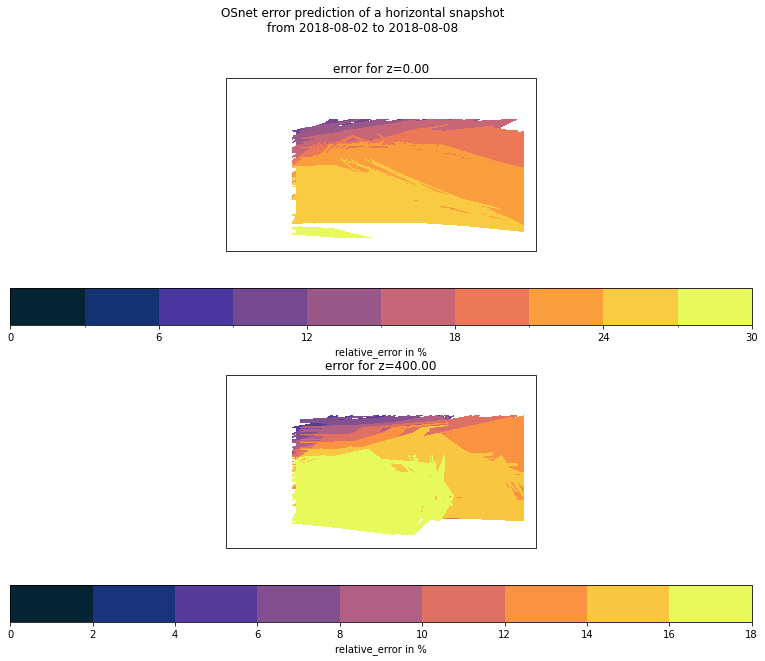

In [13]:
ds_out = output_list['snapshot']

#DataSet without N_PROF for the visualization 
ds_out_no_nprof = ds_out.drop_vars('N_PROF')
ds_out_no_nprof = ds_out_no_nprof.isel(N_PROF=0)

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(20,10), sharex=True, sharey=True, subplot_kw={"projection": ccrs.PlateCarree()})
ax = np.array(ax).flatten()
vlist = ['temp_adj']
    
for i, v in enumerate([(z,v) for z in [0,400] for v in vlist]):
    z, vname = v[0], v[1]
    if 'PRES_INTERPOLATED' in ds_out[vname].dims:
        this = ds_out_no_nprof[vname].isel(time=0).sel(PRES_INTERPOLATED=z, method='nearest')
    else:
        this = ds_out_no_nprof[vname].isel(time=0)

    add_map(ax[i])
    cs = this.plot.contourf(x='lon', ax=ax[i], levels=12, cmap=cmapd[vname], cbar_kwargs={'orientation':'horizontal', 'label':'relative_error in %'})
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title("%s for z=%0.2f" % ('error', z))
fig.suptitle('OSnet error prediction of a horizontal snapshot\nfrom %s to %s' % (pd.to_datetime(ds_out['time'].values[0]).strftime('%Y-%m-%d'),pd.to_datetime(ds_out['time'].values[len(ds_out['time'])-1]).strftime('%Y-%m-%d')));

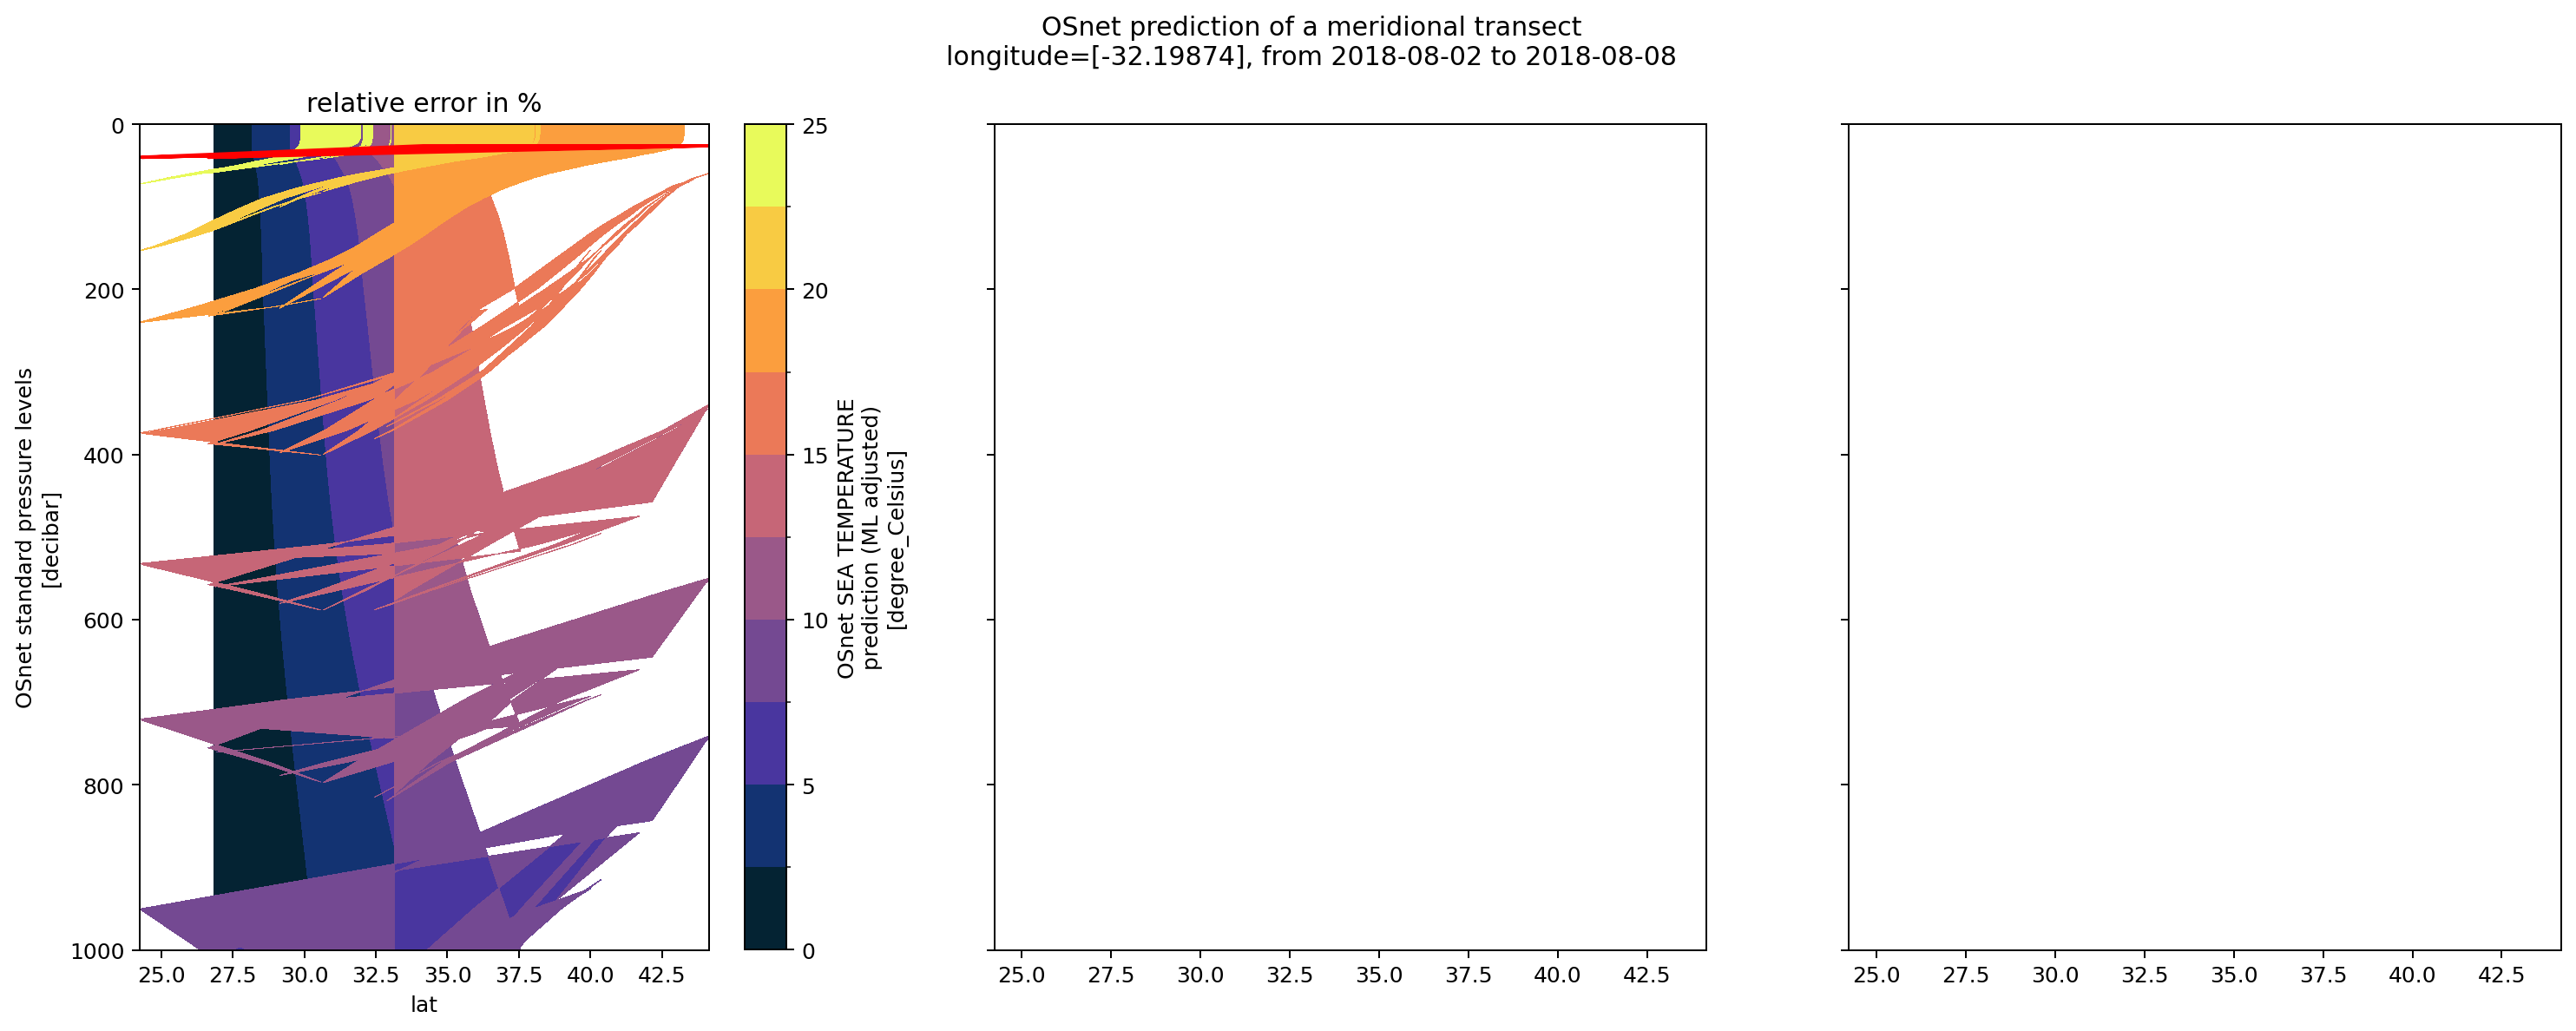

In [14]:
#Coupe pour une longitute donnée
ds_out_one_lon = output_list['meridional_transect']

#New variable relative_error in the xarray
ds_out_one_lon = ds_out_one_lon.assign(relative_error=ds_out_one_lon.temp_adj)

#Profiles
for i in range(len(ds_out_one_lon['N_PROF'])):
    #Pressure levels
    for j in range(len(ds_out_one_lon['PRES_INTERPOLATED'])):
        #Error computing
        ds_out_one_lon['temp_adj'][j][0][0][0][i] = (abs(ds_out_one_lon['temp'][j][0][0][0][i] - ds_interp['TEMP'][i][j])) / (max_temp_data - min_temp_data)
        ds_out_one_lon['relative_error'][j][0][0][0][i] = (abs(ds_out_one_lon['temp'][j][0][0][0][i] - ds_interp['TEMP'][i][j])) / (max_temp_data - min_temp_data) 

#DataSet without N_PROF for the visualization 
ds_out_one_lon = ds_out_one_lon.drop_vars('N_PROF')
ds_out_one_lon = ds_out_one_lon.isel(N_PROF=0)

        
if 'temp_adj' in ds_out_one_lon:
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20,7), dpi=180, sharex=True, sharey=True)
    ax = np.array(ax).flatten()
    vlist = ['temp_adj']
else:
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,7), dpi=180, sharex=True, sharey=True)
    ax = np.array(ax).flatten()
    vlist = ['temp_adj']
    
for i, v in enumerate(vlist):
    this = ds_out_one_lon[v].isel(time=0, lon=0)
    this.plot.contourf(x='lat', ax=ax[i], levels=12, cmap=cmapd[v], yincrease=False)
    ax[i].plot(ds_out_one_lon['lat'], ds_out_one_lon['mld'].isel(time=0, lon=0), 'r')
#     ax[i].set_xlabel('')
#     ax[i].set_ylabel('')
    ax[i].set_title("relative error in %")
fig.suptitle('OSnet prediction of a meridional transect\nlongitude=%s, from %s to %s' % (ds_out_one_lon['lon'].data, pd.to_datetime(ds_out_one_lon['time'].values[0]).strftime('%Y-%m-%d'), pd.to_datetime(ds_out_one_lon['time'].values[len(ds_out_one_lon['time'])-1]).strftime('%Y-%m-%d')));

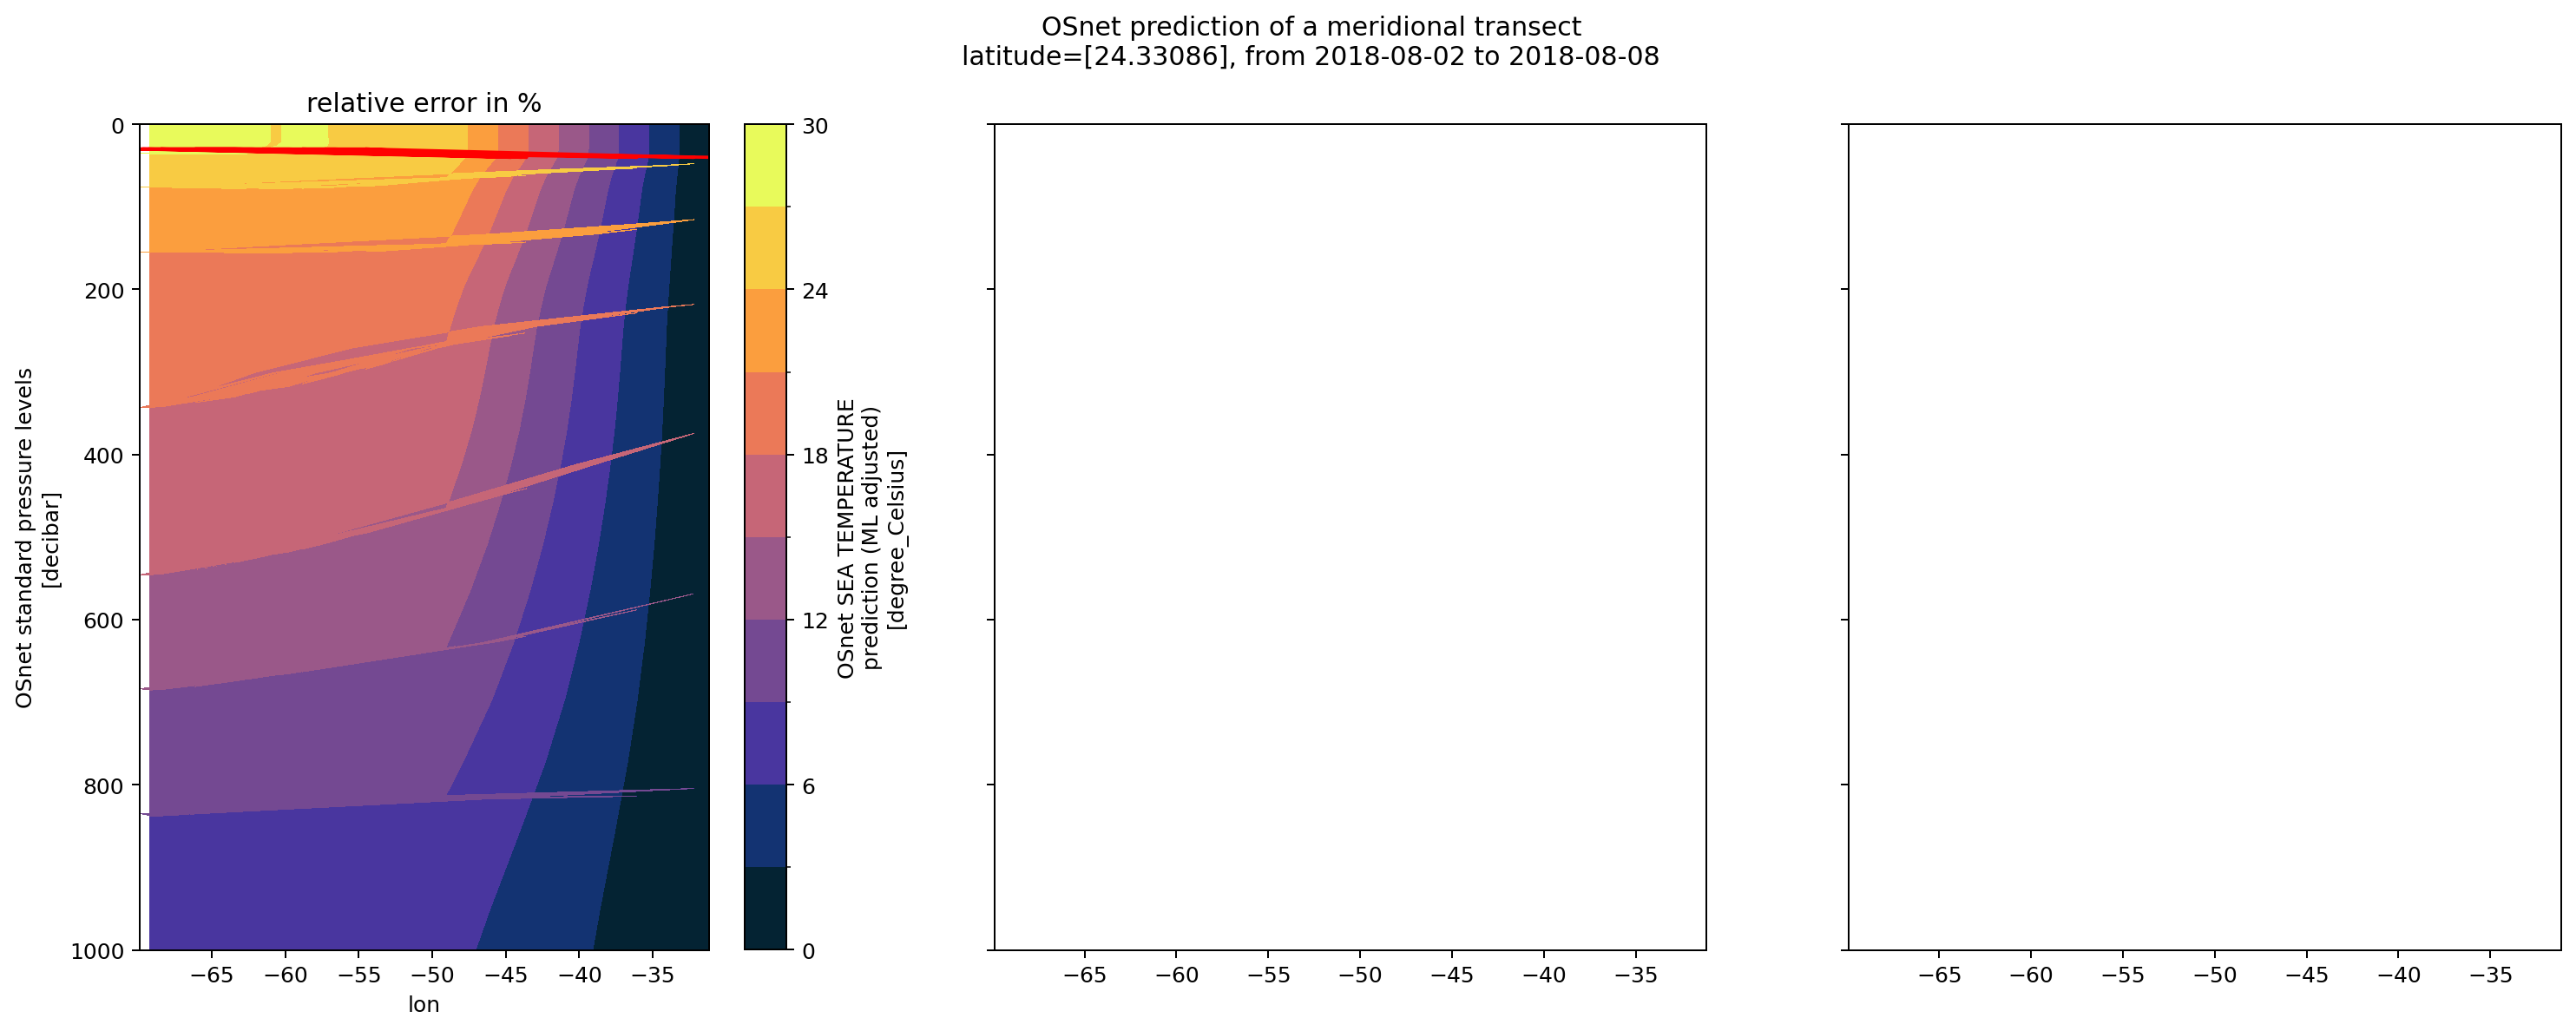

In [15]:
#Coupe pour une latitude donnée
ds_out_coupe_lat = output_list['zonal_transect']

#New variable relative_error in the xarray
ds_out_coupe_lat = ds_out_coupe_lat.assign(relative_error=ds_out_coupe_lat.temp_adj)

for i in range(len(ds_out_coupe_lat['N_PROF'])):
    for j in range(len(ds_out_coupe_lat['PRES_INTERPOLATED'])):
        ds_out_coupe_lat['temp_adj'][j][0][0][0][i] = (abs(ds_out_coupe_lat['temp'][j][0][0][0][i] - ds_interp['TEMP'][i][j])) / (max_temp_data - min_temp_data)
        ds_out_coupe_lat['relative_error'][j][0][0][0][i] = (abs(ds_out_coupe_lat['temp'][j][0][0][0][i] - ds_interp['TEMP'][i][j])) / (max_temp_data - min_temp_data) 

#DataSet without N_PROF for the visualization
ds_out_coupe_lat = ds_out_coupe_lat.drop_vars('N_PROF')
ds_out_coupe_lat = ds_out_coupe_lat.isel(N_PROF=0)

if 'temp_adj' in ds_out_coupe_lat:
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20,7), dpi=180, sharex=True, sharey=True)
    ax = np.array(ax).flatten()
    vlist = ['temp_adj']
else:
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,7), dpi=180, sharex=True, sharey=True)
    ax = np.array(ax).flatten()
    vlist = ['temp_adj']
    
for i, v in enumerate(vlist):
    this = ds_out_coupe_lat[v].isel(time=0, lat=0)
    this.plot.contourf(x='lon', ax=ax[i], levels=12, cmap=cmapd[v], yincrease=False)
    ax[i].plot(ds_out_coupe_lat['lon'], ds_out_coupe_lat['mld'].isel(time=0, lat=0), 'r')
    ax[i].set_title("relative error in %")
fig.suptitle('OSnet prediction of a meridional transect\nlatitude=%s, from %s to %s' % (ds_out_coupe_lat['lat'].data, pd.to_datetime(ds_out_coupe_lat['time'].values[0]).strftime('%Y-%m-%d'), pd.to_datetime(ds_out_one_lon['time'].values[len(ds_out_coupe_lat['time'])-1]).strftime('%Y-%m-%d'))); 

***

In [ ]:
osnet.disclaimer()
osnet.show_versions()